In [84]:
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import math

import pandas as pd
import datetime as dt
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

### Getting Data from Alpaca Markets


In [53]:
df_stocks = pd.read_csv('data/jpm_bars_2024-03-06.csv')

In [54]:
# Reset the index
df_stocks['timestamp'] = df_stocks.timestamp.apply(lambda x: x.split(' ')[0])
df_stocks.rename(columns={'timestamp': 'date'}, inplace=True)
df_stocks.drop(['symbol'], axis=1, inplace=True)
df_stocks.set_index('date', inplace=True)

In [55]:
df = df_stocks.copy()

### Data Exploration

In [56]:
# Double check the result
df.head()

,open,high,low,close,volume,trade_count,vwap
date,,,,,,,
2016-01-04,63.95,64.060,63.01,63.62,27827227.0,145804.0,63.451452
2016-01-05,63.69,64.130,63.04,63.73,17591872.0,103027.0,63.519312
2016-01-06,62.70,63.125,62.34,62.81,24407202.0,124497.0,62.745693
2016-01-07,61.46,62.000,60.08,60.27,29310297.0,166584.0,60.834008
2016-01-08,61.13,61.270,58.85,58.92,24651311.0,135242.0,59.791316


In [57]:
df.tail()

,open,high,low,close,volume,trade_count,vwap
date,,,,,,,
2024-02-28,183.43,185.20,182.96,184.38,6131608.0,90914.0,184.413387
2024-02-29,185.66,186.43,183.85,186.06,9642256.0,100032.0,185.571020
2024-03-01,185.70,186.44,185.10,185.29,6311997.0,93783.0,185.490087
2024-03-04,184.71,187.59,184.27,186.68,7062259.0,113106.0,186.647544
2024-03-05,186.36,189.30,186.36,188.55,6618615.0,109782.0,188.315997


### Data Visualization

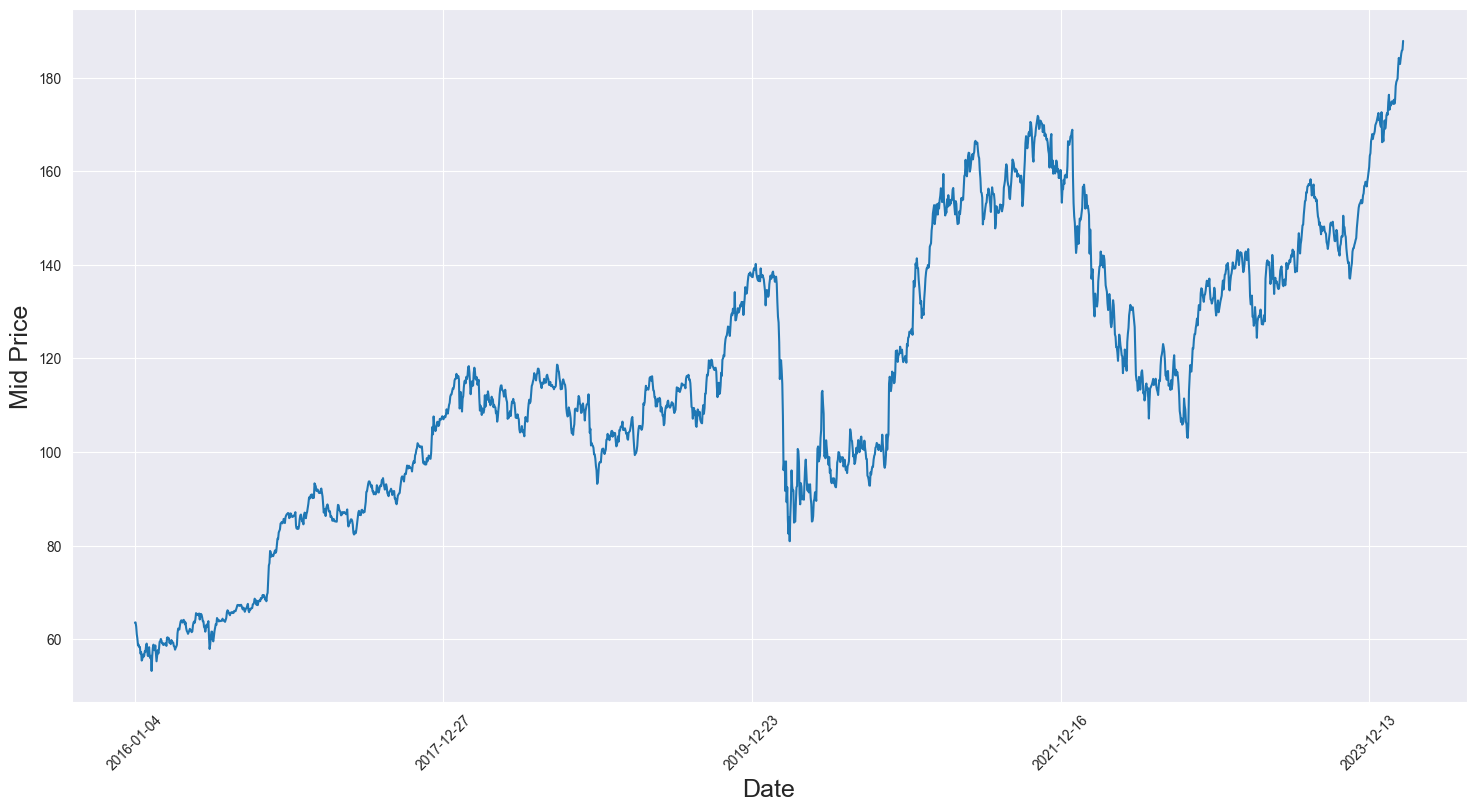

In [58]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['low']+df['high'])/2.0)
plt.xticks(range(0,df.shape[0],500),df.index[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

### Splitting Data into a Training set and a Test set

In [59]:
# First calculate the mid prices from the highest and lowest
high_prices = df.loc[:,'high'].values
low_prices = df.loc[:,'low'].values
mid_prices = (high_prices+low_prices)/2.0

In [60]:
split_idx = df.shape[0]*1//7
train_data = mid_prices[:-split_idx]
test_data = mid_prices[-split_idx:]
print(train_data.shape[0], split_idx, (df.shape[0]*6)//7, df.shape[0])

1763 293 1762 2056


In [61]:
split_idx

293

### Normalizing the Data

In [62]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [63]:
# Train the Scaler with training data and smooth data
smoothing_window_size = split_idx
for di in range(0,df.shape[0]*4//5 + 1,smoothing_window_size):
    try:
        scaler.fit(train_data[di:di+smoothing_window_size,:])
        train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])
    except:
        print(di)

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [64]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.fit_transform(test_data).reshape(-1)

In [65]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(train_data.shape[0]):
    EMA = gamma*train_data[ti] + (1-gamma)*EMA
    train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

### Standard Average

In [66]:
window_size = 100
N = train_data.size
df_train = df.iloc[:N,:]
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(df_train.index[pred_idx], '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df_train.index[pred_idx]

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.02221


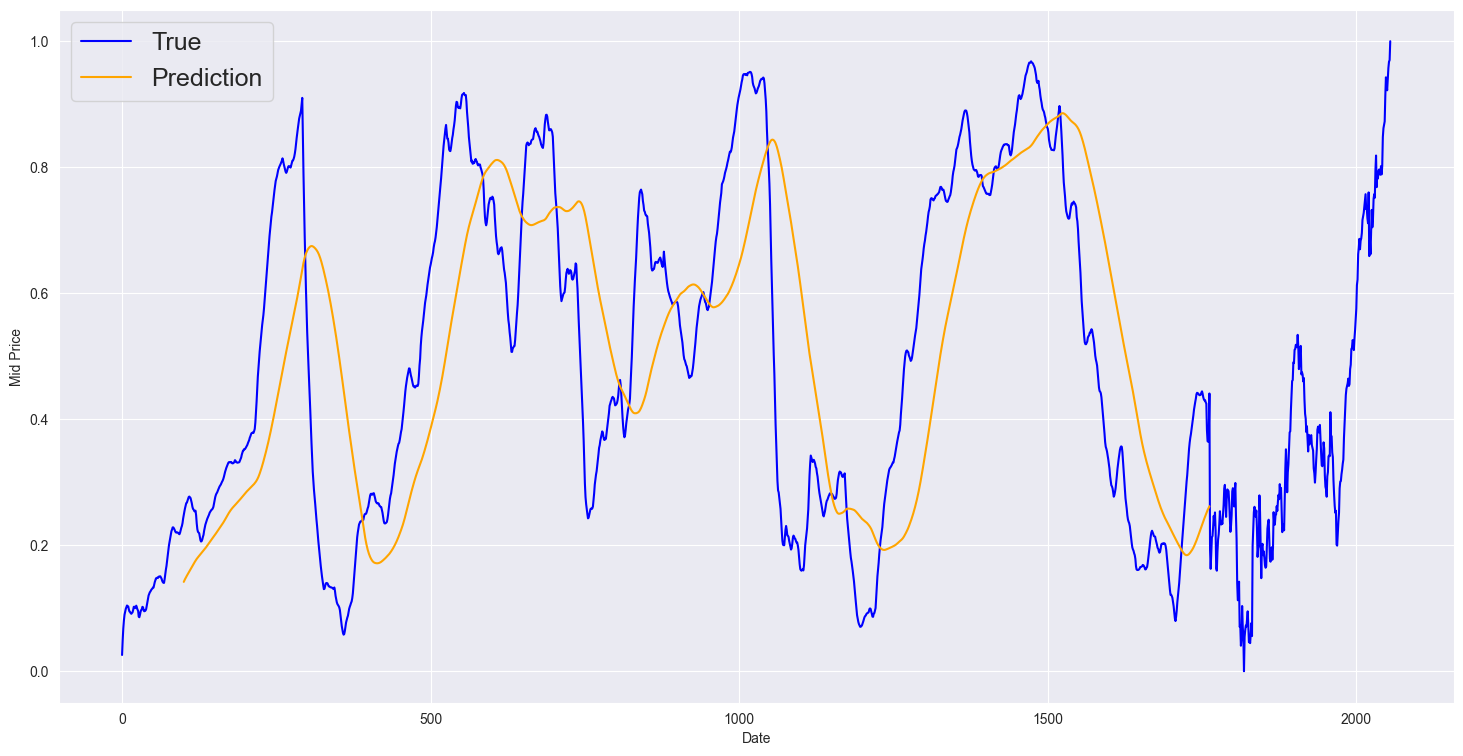

In [67]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

### Exponential Moving Average

In [68]:
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00016


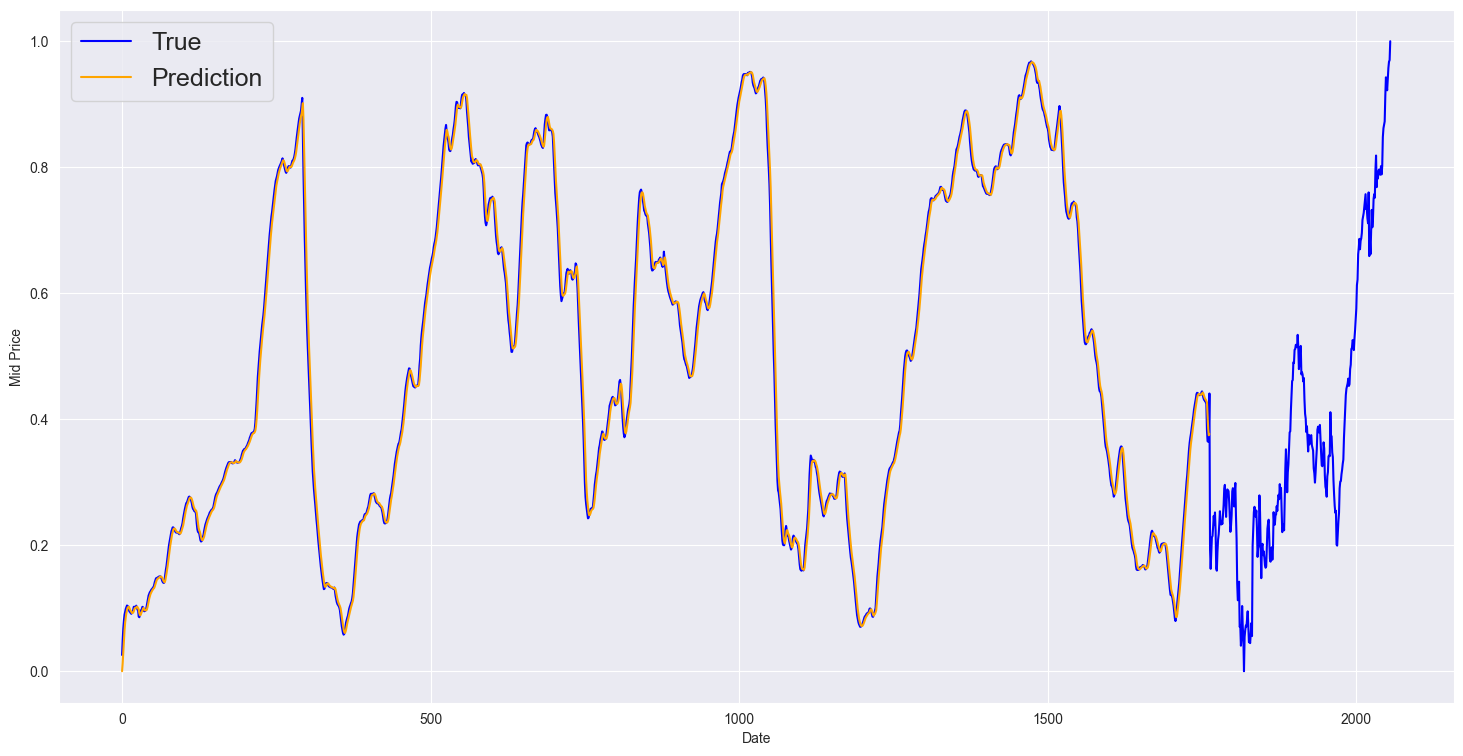

In [77]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

### LSTM: Stock Movement Predictions Far into the Future

In [79]:
### Data Augmentation

In [80]:
class DataGeneratorSeq(object):

    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))


In [81]:
dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

In [82]:
for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [0.02576702 0.10334449 0.7590574  0.6147421  0.7577963 ]

	Output: [0.04908207 0.07936672 0.719667   0.5713569  0.75619817]


Unrolled index 1
	Inputs:  [0.04908207 0.10114069 0.74726075 0.5713569  0.75619817]

	Output: [0.06793914 0.10114069 0.7028282  0.47202167 0.76647174]


Unrolled index 2
	Inputs:  [0.06793914 0.096864   0.7339358  0.5430337  0.75567085]

	Output: [0.08068875 0.07176361 0.6531347  0.5430337  0.7725121 ]


Unrolled index 3
	Inputs:  [0.08068875 0.08818524 0.719667   0.50281346 0.7560947 ]

	Output: [0.09427907 0.07176361 0.67866004 0.50281346 0.7725121 ]


Unrolled index 4
	Inputs:  [0.0897189  0.07936672 0.7028282  0.47202167 0.76105016]

	Output: [0.09427907 0.06647746 0.6531347  0.43267438 0.78948665]


### Defining Hyperparameters

In [85]:
D = 1 # Dimensionality of the data. Since your data is 1-D this would be 1
num_unrollings = 50 # Number of time steps you look into the future.
batch_size = 500 # Number of samples in a batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

### Defining Inputs and Outputs

In [86]:
# Input data.
train_inputs, train_outputs = [],[]

# You unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))

AttributeError: module 'tensorflow' has no attribute 'placeholder'